[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sascha-senko/TensorflowCourse/blob/main/Cifar10dense.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
BATCH_SIZE = 128
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
train_percent = 80
# hyperparameters
# müssen wir für batchnormalization auch den gamma und beta parameter anpassen?
LAMBDA = 0.01  # factor for l2
DROP = 0.1 # dropout rate

170500096/170498071 [==============================] - 2s 0us/step


(32, 32, 3)

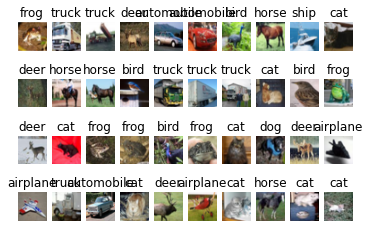

In [3]:
train_dataset, test_dataset = tf.keras.datasets.cifar10.load_data()

train_images, train_labels = train_dataset
images_slice = train_images[0:40].reshape(4, 10, 32, 32, 3)
labels_slice = train_labels[0:40].reshape(4, 10, 1)
translate_labels = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
fig, ax = plt.subplots(4, 10)

for i in range(4):
  for j in range(10):
    if j == 10:
      break
    ax[i, j].imshow(images_slice[i,j])
    ax[i, j].set_title(translate_labels[labels_slice[i,j][0]])
    ax[i, j].axis("off")
train_images[0].shape


In [4]:
def normalize(image):
  image = image/255
  return image

def pipeline(data):
  data = tf.data.Dataset.from_tensor_slices(data)
  data = data.map(lambda image, label: (normalize(image), tf.one_hot(label, 10)))
  data = data.batch(BATCH_SIZE)
  data = data.shuffle(buffer_size=BATCH_SIZE)
  data = data.prefetch(PREFETCH_SIZE)
  return data

In [5]:
# preprocess all data
processed_train_data = pipeline(train_dataset)
processed_test_data = pipeline(test_dataset)

In [17]:
class DenseBlock(tf.keras.layers.Layer):
  def __init__(self, layers= 5, filters= 10):
    super(DenseBlock, self).__init__()
    self.dense_layers = []
    for i in range(layers):
      self.dense_layers.append(Conv2D(filters=filters, kernel_size=(3,3), padding= 'same', activation=None))
      self.dense_layers.append(tf.keras.layers.BatchNormalization())
      self.dense_layers.append(tf.keras.layers.ReLU())
    self.concat = tf.keras.layers.Concatenate()
  
  def call(self, input):
    x = input
    for l in self.dense_layers:
      y = l(x)
      x = self.concat([x, y])
    return x



  

In [23]:
class TransitionLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters = 32):
    super(TransitionLayer, self).__init__()
    self.conv = Conv2D(filters= num_filters, kernel_size=(1,1), activation=None)
    self.relu = tf.keras.layers.ReLU()
    self.batch = tf.keras.layers.BatchNormalization()
    self.pool = tf.keras.layers.AveragePooling2D()
  
  def call(self, input):
    x = input
    x = self.conv(x)
    x = self.batch(x)
    x = self.pool(x)
    return x

In [28]:
class DenseNet(tf.keras.Model):
  def __init__(self, block_num= 5, growth_rate= 5, block_length= 3):
    super(DenseNet, self).__init__()
    self.conv_1 = Conv2D(filters= (growth_rate * 2), kernel_size= 3, padding= 'same', activation=None)
    self.batch_1 = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.dense_block = []
    for i in range(block_num):
      growth_rate = growth_rate * i
      self.dense_block.append(DenseBlock(layers= block_length, filters= growth_rate))
      if i < (block_num - 1):
        self.dense_block.append(TransitionLayer(num_filters= (block_length * growth_rate)))

    self.average = tf.keras.layers.GlobalAveragePooling2D()
    self.dense = tf.keras.layers.Dense(units= 10, activation= 'softmax')

  def call(self, input, training = False):
    x = self.conv_1(input)
    x = self.batch_1(x)
    x = self.relu(x)
    for l in self.dense_block:
      x = l(x)
    x = self.average(x)
    x = self.dense(x)
    x = tf.expand_dims(x, axis=1)
    return x

In [12]:
# train step and test step functions
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=-1) == np.argmax(prediction, axis=-1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

def visualize(train_losses, test_losses, test_accuracies):
  # visualize training progress
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()

  plt.figure()
  line1, = plt.plot(test_accuracies)
  plt.title(' max accuracy: '+ str(np.max(test_accuracies)))
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  #plt.set_ylim([0,1])
  plt.show()
  
def calc_stat(stat_so_far, new_stat, stat_num):
    """Calculates appropriate statistic

    :param stat_so_far: the statistic that we have observed so far
    :param new_stat: the newest observed statistic
    :param stat_num: new_stat is the stat_num-th observed statistic
    :return: if 0, return mean, else running average
    """

    if running_average_factor:
        return running_average_factor * stat_so_far + (1 - running_average_factor) * new_stat
    # calculate mean of observed statistics so far
    return ((stat_num - 1) * stat_so_far + new_stat) / stat_num


Epoch: __ 0


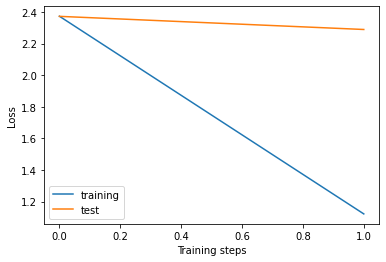

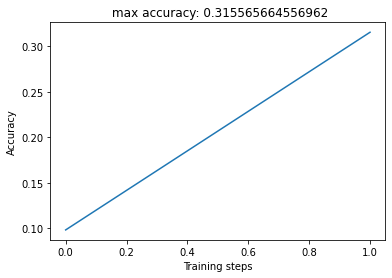

Epoch: __ 1


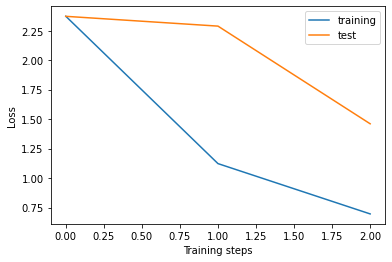

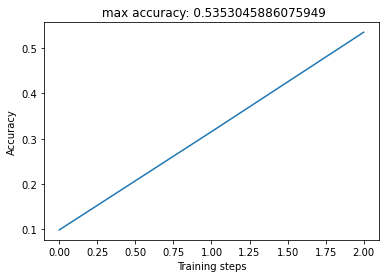

Epoch: __ 2


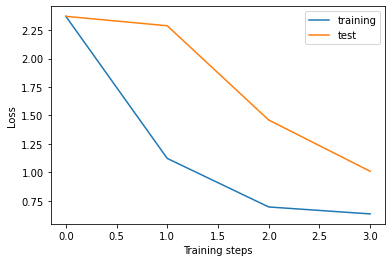

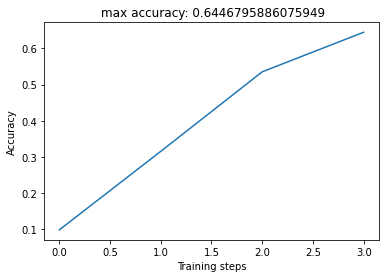

Epoch: __ 3


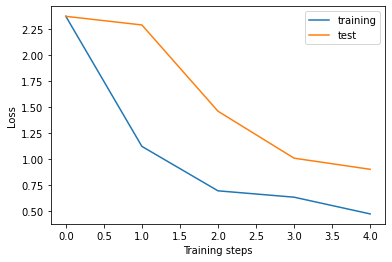

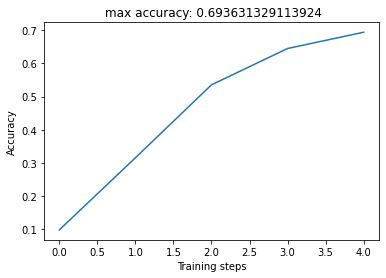

Epoch: __ 4


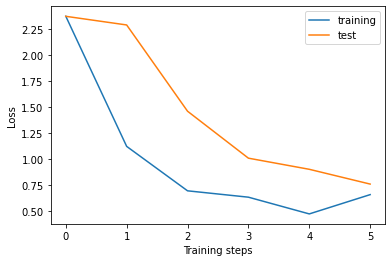

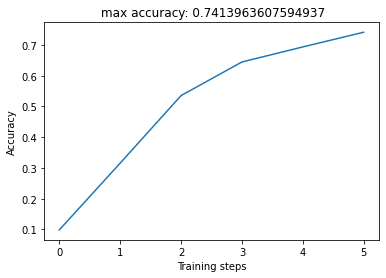

Epoch: __ 5


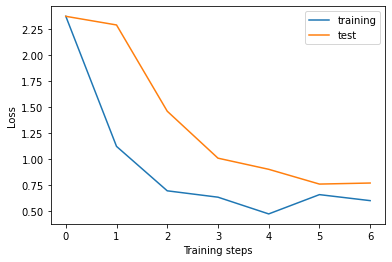

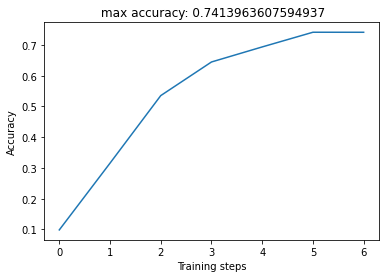

Epoch: __ 6


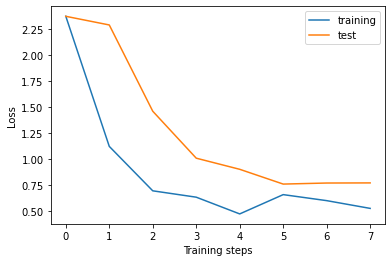

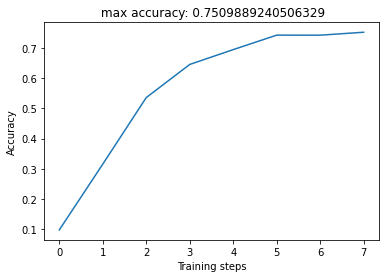

Epoch: __ 7


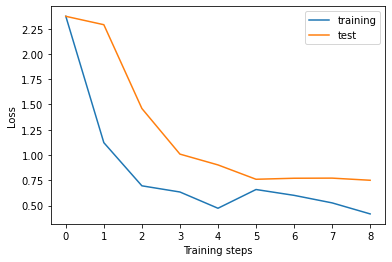

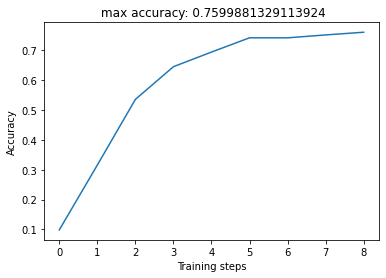

Epoch: __ 8


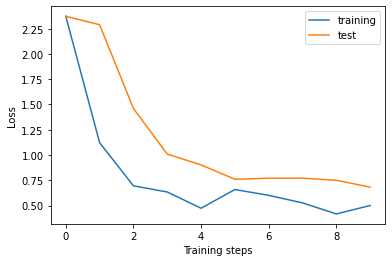

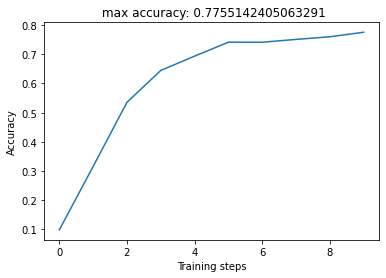

Epoch: __ 9


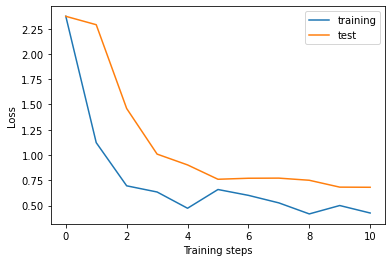

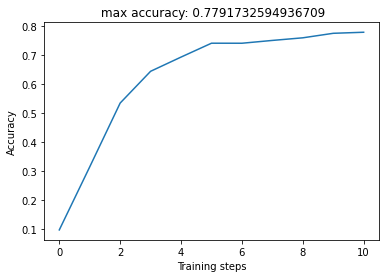

In [30]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
running_average_factor = 0.1

# Initialize the model.
model = DenseNet()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
categorical_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, processed_test_data, categorical_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, processed_train_data, categorical_entropy_loss)
train_losses.append(train_loss)


# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = processed_train_data.shuffle(buffer_size=128)
    test_dataset = processed_test_data.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    train_loss_stat = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, categorical_entropy_loss, optimizer) 
        train_loss_stat = calc_stat(train_loss_stat, train_loss, i+1)
    train_losses.append(train_loss_stat)


    #testing
    test_loss, test_accuracy = test(model, test_dataset, categorical_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    visualize(train_losses, test_losses, test_accuracies)

In [ ]:
for (input, target) in processed_train_data:
  print(input)